In [52]:
"""
FOR microscopic
- Generate Hfull with np.kro
- Calculate Gn & H
- Find the ground state
- Calculate G(U)
"""
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [64]:
## DEFINE FERMIONIC AND SPIN OPERATORS


c = np.array([[0,0], [1,0]])
cD = np.array([[0,1], [0,0]])

S = 1/2
dimS = int(2*S+1)
dimF = 2

def spinsMatrices(S):
    dim =  int(2*S+1)
    values = np.flip(np.arange(-S,S+1,1))
    Sz = np.diag(values)
    Sp = np.eye(dim,k=1)
    Sm = np.eye(dim,k=-1)
    return Sz,Sp,Sm

sz,sp,sm = spinsMatrices(S)

C = np.kron(c,np.eye(dimS))
CD = np.kron(cD,np.eye(dimS))


Sz = np.kron(np.eye(dimF),sz)
Sp = np.kron(np.eye(dimF),sp)
Sm = np.kron(np.eye(dimF),sm)

In [65]:
#Construct global operator (on Hfull) from local operator
def localToGlobal(n,N,O):
    if n >=N or n<0:
        print("ERREUR localToGlobal")
        return 0
    dim = O.shape[0]
    On = np.kron(np.kron(np.eye(dim**(n)),O), np.eye(dim**(N-n-1)))
    return On


(256, 256)

In [66]:
def Gx(x,N):    # Compute Gauge transformation operator
    Gx = localToGlobal(x,N,CD@C) - localToGlobal(x,N,Sz) + localToGlobal((x-1)%N,N,Sz) - x%2*np.eye(4**N)
    return Gx

def Gs(N):      # Compute all Gauge transformation operators
    G = []
    for x in range(N):
        G.append(Gx(x,N))

    return G



N = 4
allG = Gs(N)
print(allG[0])

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [67]:
def hamiltonian(N=4,U=30,m=0.,tF=1.,tB=1.):     #Construct the hamiltonian
    H = np.zeros(((dimF*dimS)**N,(dimF*dimS)**N))

    for n in range(N): 
        hB = localToGlobal(n,N,Sp)
        H += -tB * (hB + np.transpose(hB))

        hF = localToGlobal((n+1)%N,N,CD)@localToGlobal(n,N,C)
        H += -tF * (hF + np.transpose(hF))

        H += m * (-1)**n * localToGlobal(n,N,CD@C)

        H += U * allG[n]@allG[n]
    return H


def electricFields(state):                      #Compute the electrical field of a state
    e = []
    for i in range(N):
        e.append(np.conj(state)@localToGlobal(i,N,Sz)@state)
    e.insert(0,e[-1])
    return e

In [86]:
tB=1.
tF = 1.
m=0.2
U= 20.
H = hamiltonian(N,U,m,tF,tB)
print(H)

[[ 40.   -1.    0.  ...   0.    0.    0. ]
 [ -1.   40.    0.  ...   0.    0.    0. ]
 [  0.    0.   60.2 ...   0.    0.    0. ]
 ...
 [  0.    0.    0.  ...  19.8   0.    0. ]
 [  0.    0.    0.  ...   0.  120.   -1. ]
 [  0.    0.    0.  ...   0.   -1.   40. ]]


(256,)


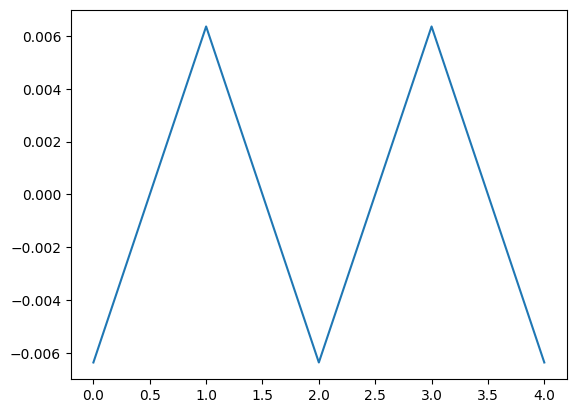

[-0.006357543707980279, 0.006357543832063051, -0.006357543707985885, 0.006357543832062829, -0.006357543707980279]


In [87]:
Energie,P = np.linalg.eigh(H)       #diagonalize H
print(Energie.shape)


#plt.plot(electricFields(P[:,0]))
#plt.show()
#print(electricFields(P[:,0]))

In [88]:
def computeG(state):    #Compute expected G for a given state
    G = 0
    for Gx in allG:
        G+= np.abs(state@Gx@state)
    return G

In [96]:
def GfuncofU(N,U):      #Compute G for the ground state of H(U)
    m=-0.
    Energie,P = np.linalg.eigh(hamiltonian(N,U,m))#H0 + Hu(N,U))
    return computeG(P[:,0])

In [97]:
U = np.array([5,10,20,40,80,160, 320,640])
gs = np.zeros(len(U))

for i,u in tqdm(enumerate(U)):
    gs[i] = GfuncofU(N,u)
print(gs.tolist())


8it [00:00, 14.43it/s]

[0.03024201293932167, 0.007938511289934077, 0.00199730647963661, 0.0004998514401480909, 0.00012499103152813034, 3.124944444497529e-05, 7.812465355768754e-06, 1.953122835969935e-06]


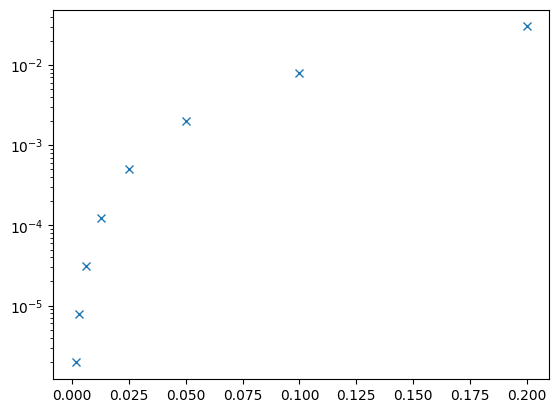

In [79]:
plt.plot(1/U,gs,'x')
plt.yscale("log")
#plt.xscale("log")
plt.show()

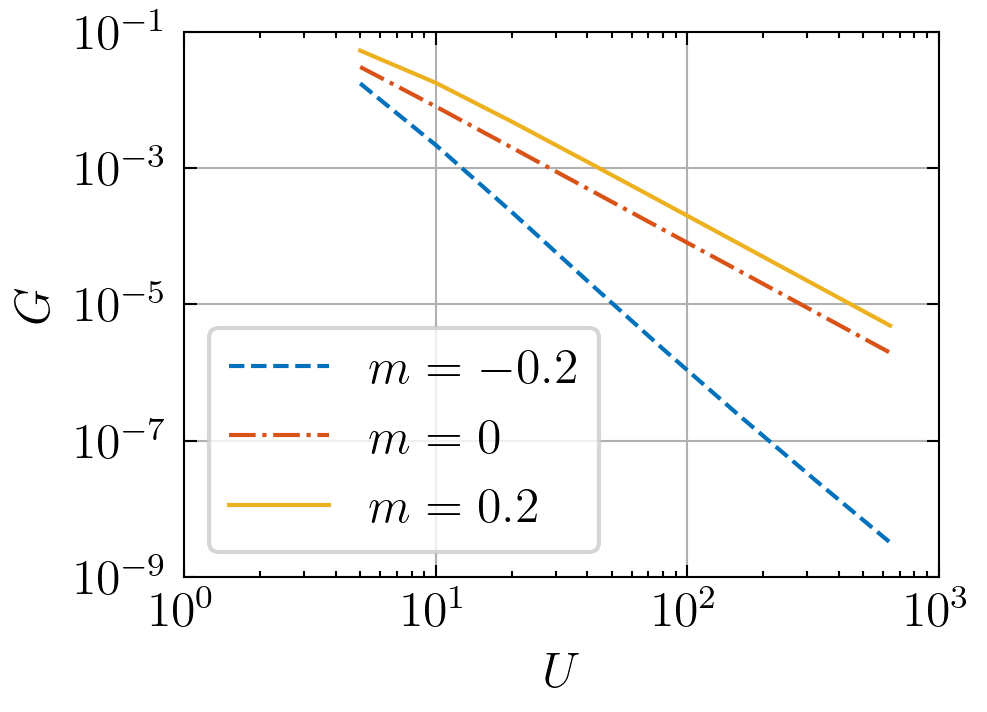

In [118]:
gsm=np.array([[0.017348098077338982, 0.002162307871827826, 0.00022683908224488414, 2.2128589657639565e-05, 2.2193843635991797e-06, 2.380347312612574e-07, 2.713453715274935e-08, 3.2233252351756202e-09],
              [0.03024201293932167, 0.007938511289934077, 0.00199730647963661, 0.0004998514401480909, 0.00012499103152813034, 3.124944444497529e-05, 7.812465355768754e-06, 1.953122835969935e-06],
              [0.05260997641161752, 0.01767215390749552, 0.004795822989536618, 0.001230543340243655, 0.0003104850991240967, 7.790080148799942e-05, 1.9505010531345548e-05, 4.8796460139553e-06]])


plt.style.use(["science"])
color = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE", "#A2142F"]

cm = 1 / 2.54
maxsize = 5.9

fig= plt.figure(figsize=(0.55*maxsize, 6 * cm), dpi=300)
ax=plt.gca()    


plt.plot(U,gsm[0],'--',color=color[0], label="$m=-0.2$")
plt.plot(U,gsm[1],'-.',color=color[1], label="$m=0$")
plt.plot(U,gsm[2],'-',color=color[2], label="$m=0.2$")


plt.yscale("log")
plt.xscale("log")

plt.rcParams["font.size"] = "12"
plt.ylabel(r"$G$", fontsize=12)
plt.xlabel(r"$U$", fontsize=12)

#plt.xticks(x[::2])
#plt.yticks([-0.5,-0.25,0,0.25,0.5],["$-1/2$","","$0$","","$1/2$"])

plt.xlim([1,1e3])
plt.ylim([1e-9,1e-1])

#plt.tick_params(left = False,top=False,right=False) 
#plt.minorticks_off()
plt.grid()
plt.legend(frameon=True)


plt.savefig("IMG/microToQLM.png", bbox_inches="tight")
plt.show()